In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from functools import partial
from typing import Optional
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
from IPython.display import clear_output
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
USE_CUDA = torch.cuda.is_available()

print("cuda is available:", USE_CUDA)

cuda is available: True


# Data

In [4]:
import numpy as np
from typing import Tuple

import torchvision


def load_MNIST() -> Tuple[np.ndarray, np.ndarray]:
    train_data = torchvision.datasets.MNIST(root="./", train=True, download=True)
    test_data = torchvision.datasets.MNIST(root="./", train=False, download=True)
    train_data, test_data = train_data.data.numpy(), test_data.data.numpy()
    axis_index = len(train_data.shape)
    train_data = np.expand_dims(train_data, axis=axis_index)
    test_data = np.expand_dims(test_data, axis=axis_index)

    return train_data, test_data


def load_CIFAR10() -> Tuple[np.ndarray, np.ndarray]:
    train_data = torchvision.datasets.CIFAR10(root="./", train=True, download=True)
    test_data = torchvision.datasets.CIFAR10(root="./", train=False, download=True)
    train_data, test_data = train_data.data, test_data.data

    return train_data, test_data


def _load_dataset(name: str) -> Tuple[np.ndarray, np.ndarray]:
    if name == "mnist":
        return load_MNIST()
    elif name == "cifar10":
        return load_CIFAR10()
    else:
        raise ValueError("The argument name must have the values 'mnist' or 'cifar10'")


def load_dataset(
    name: str, flatten: bool = False, binarize: bool = False
) -> Tuple[np.ndarray, np.ndarray]:

    train_data, test_data = _load_dataset(name)

    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if binarize:
        train_data = (train_data > 128).astype("float32")
        test_data = (test_data > 128).astype("float32")
    else:
        train_data = train_data / 255.0
        test_data = test_data / 255.0

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    if flatten:
        train_data = train_data.reshape(len(train_data.shape[0]), -1)
        test_data = test_data.reshape(len(train_data.shape[0]), -1)

    return train_data, test_data

In [5]:
train_data, test_data = load_dataset('cifar10')

100%|██████████| 170498071/170498071 [00:13<00:00, 12786557.67it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [6]:
train_data.shape

(50000, 3, 32, 32)

In [7]:
BATCH_SIZE = 64
cifar_dataset = TensorDataset(torch.from_numpy(train_data)) # create your datset
cifar_dataloader = DataLoader(cifar_dataset, batch_size=BATCH_SIZE)

In [63]:
distances = []
for batch in cifar_dataloader:
  batch = batch[0].reshape(1, BATCH_SIZE, -1)
  distances.append(torch.mean(torch.cdist(batch, batch)))

(array([  1.,   0.,   0.,   0.,   0.,   0.,  10., 226., 495.,  50.]),
 array([ 9.07940292, 10.2432394 , 11.40707493, 12.57091141, 13.73474693,
        14.89858341, 16.06241989, 17.22625542, 18.39009094, 19.55392838,
        20.7177639 ]),
 <BarContainer object of 10 artists>)

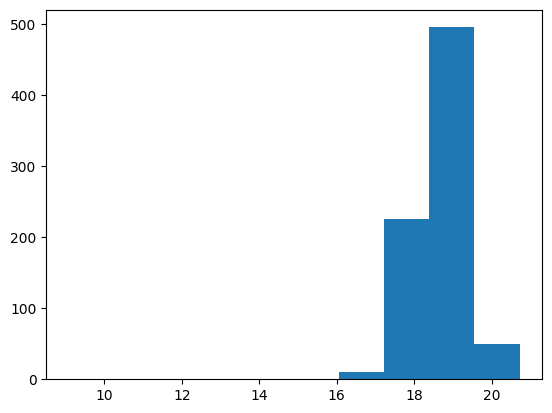

In [64]:
plt.hist(distances)

# Model

In [8]:
from models import NoiseConditionalScoreNetwork

In [9]:
class NoiseConditionalScoreNetwork(nn.Module):
  def __init__(self, n_channels: int = 1, num_classes: int = 10, ngf: int = 64, image_size: int = 28) -> None:
    super().__init__()

    self.image_size = image_size
    self.n_channels = n_channels
    self.net = CondRefineNetDilated(image_size, num_classes, n_channels, ngf)


  def forward(self, input: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
    return self.net(input, sigma)

  def prior(self, n_samples):
    # sample from prior distribution
    noise = torch.randn(n_samples, self.n_channels, self.image_size, self.image_size)
    if USE_CUDA:
      return noise.cuda()
    return noise


  def sample(self, n_samples: int,
             n_steps: int,
             sigmas: torch.Tensor,
             eps: float = 0.00005,
             save_history: bool = False,
             save_freq: int = 100) -> torch.Tensor:
    history = []
    if isinstance(n_steps, int):
      n_steps = [n_steps]*len(sigmas)

    with torch.no_grad():
      for i, sigma in enumerate(sigmas):
        alpha = eps * sigma**2 / sigmas[-1]**2
        for k in range(n_steps[i]):
          sigma_batch = torch.ones(n_samples, device=x_k.device, dtype=torch.int) * i
          score = self(x_k, sigma_batch)
          x_k += alpha * score.detach() / 2 + np.sqrt(alpha) * torch.randn_like(x_k)
          if save_history and k % save_freq == 0:
            history.append(x_k.cpu())

    if save_history:
      return x_k.cpu(), history

    return x_k.cpu()

# Train

In [20]:
def train_ncsn(
    model: object,
    train_loader: object,
    n_epochs: int,
    lr: float,
    sigmas: torch.Tensor,
    use_cuda: bool = False,
    weights_path: str = ''
) -> dict:

  if use_cuda:
      critic = model.cuda()
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0, 0.9))

  #curr_iter = 0
  loss_history = {"loss": []}
  for epoch_i in range(n_epochs):
    train_loss = 0
    for batch_i, x in tqdm(enumerate(train_loader)):
      x = x[0]
      batch_size = x.shape[0]
      #curr_iter += 1
      if use_cuda:
        x = x.cuda()


      labels = torch.randint(len(sigmas), (batch_size,))
      sigma_batch = sigmas[labels].to(x.device)
      #sigma_batch = sigmas[torch.randint(len(sigmas), (batch_size,))].to(x.device)
      sigma_batch = sigma_batch.reshape(-1, *([1]*(len(x.shape) - 1)))

      standart_noise = torch.randn_like(x)
      x_noisy = x + standart_noise * sigma_batch


      optimizer.zero_grad()
      #pred_scores = model(x_noisy, sigma_batch.flatten())
      pred_scores = model(x_noisy, labels.to(x.device))

      noisy_scores = (-standart_noise / sigma_batch).reshape(batch_size, -1)
      pred_scores = pred_scores.reshape(batch_size, -1)

      losses = torch.sum((pred_scores - noisy_scores)**2, axis=-1) / 2
      loss = torch.mean(losses * sigma_batch.flatten()**2)

      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_loss /= len(train_loader)
    loss_history["loss"].append(train_loss)


    clear_output()
    plt.plot(loss_history["loss"])
    plt.suptitle('%d / %d - train loss: %f' % (epoch_i + 1, n_epochs, train_loss))
    plt.show()

    if (epoch_i + 1) % 10 == 0:
      torch.save(model.state_dict(), weights_path+'_{}.pth'.format(epoch_i + 1))

  return loss_history

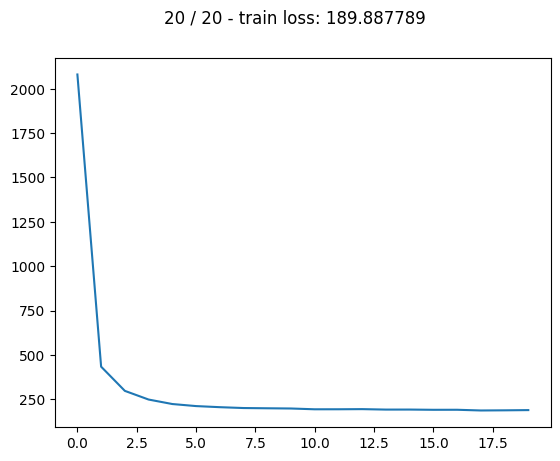

In [69]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(18), np.log(0.01), 10))).float()

refine_net = NoiseConditionalScoreNetwork(n_channels=3, ngf=64, image_size=32)

loss_history = train_ncsn(model=refine_net,
                          train_loader=cifar_dataloader,
                          n_epochs=20,
                          lr=1e-3,
                          sigmas=sigmas,
                          use_cuda=USE_CUDA)

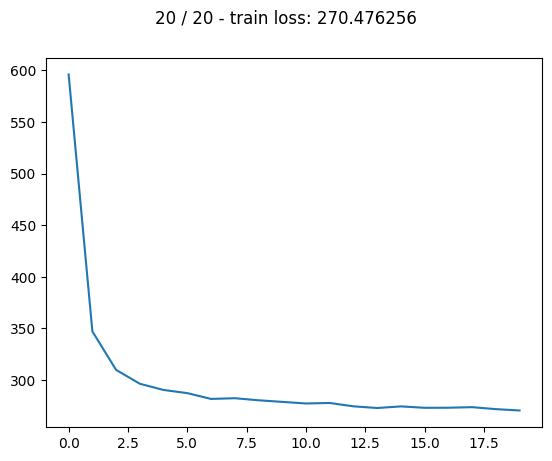

In [ ]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(1), np.log(0.01), 10))).float()

refine_net = NoiseConditionalScoreNetwork(n_channels=3, ngf=64, image_size=32)

loss_history = train_ncsn(model=refine_net,
                          train_loader=cifar_dataloader,
                          n_epochs=20,
                          lr=1e-3,
                          sigmas=sigmas,
                          use_cuda=USE_CUDA)

# Sampling

$\sigma_1 = 18$

In [ ]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(18), np.log(0.01), 10))).float()

refine_net = NoiseConditionalScoreNetwork(n_channels=3, ngf=64, image_size=32)
refine_net.load_state_dict(torch.load('/content/drive/MyDrive/NCSN/18_refine_net_20.pth'))
refine_net.cuda()

In [25]:
refine_net.eval()
#n_steps = [300, 200, 100, 100, 50, 50, 50, 50, 150, 150]
n_steps = 100
samples, history = refine_net.sample(n_samples=10, n_steps=n_steps, sigmas=sigmas, save_history=True)

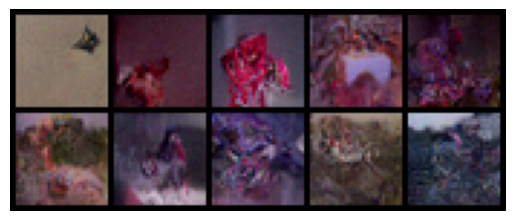

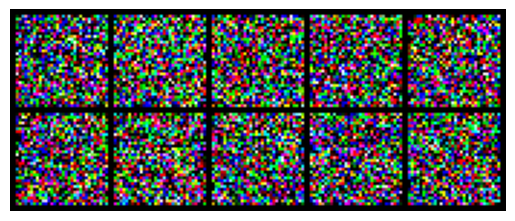

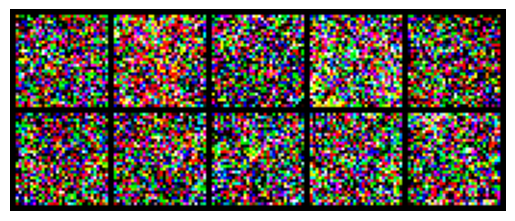

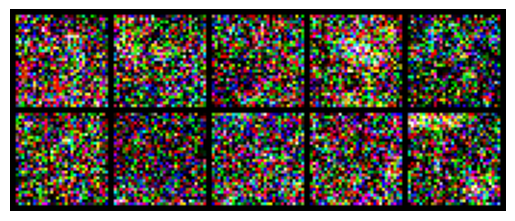

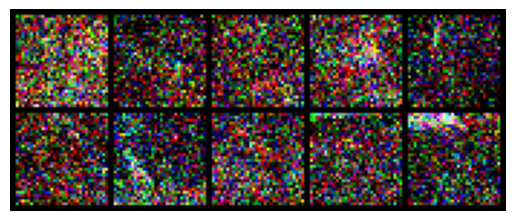

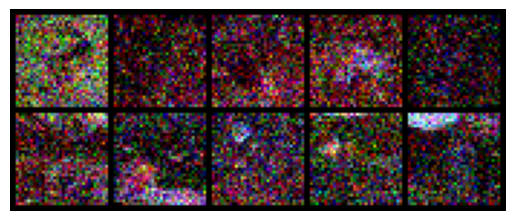

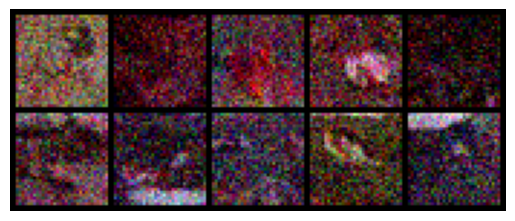

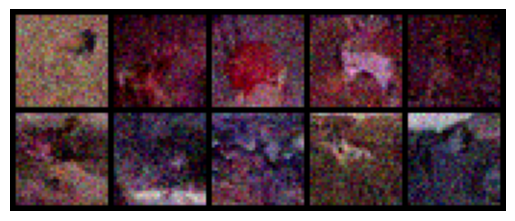

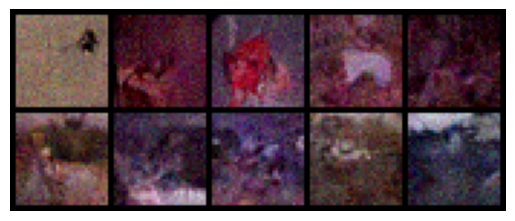

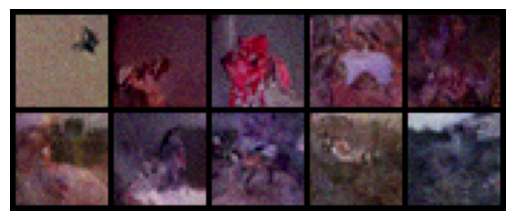

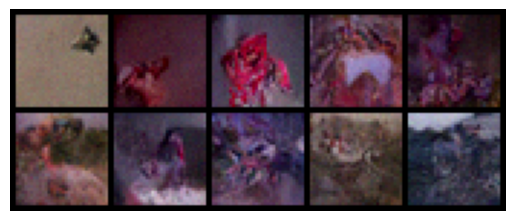

In [26]:
from torchvision.utils import make_grid

grid_samples = make_grid(samples, nrow=5)

grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
#plt.figure(figsize=(6, 6))
plt.imshow(grid_img)
plt.axis("off")
plt.show()

for step in range(len(history)):
  grid_samples = make_grid(history[step], nrow=5)

  grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
  #plt.figure(figsize=(6, 6))
  plt.imshow(grid_img)
  plt.axis("off")
  plt.show()

$\sigma_1 = 1$

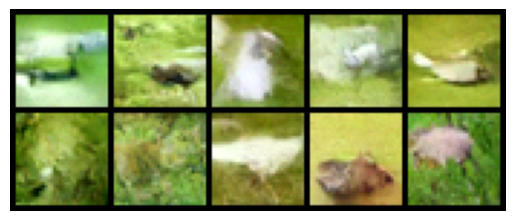

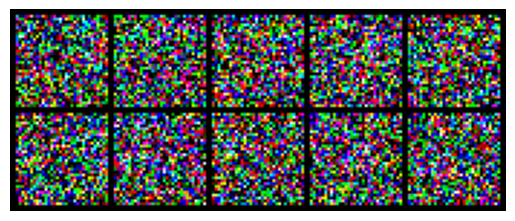

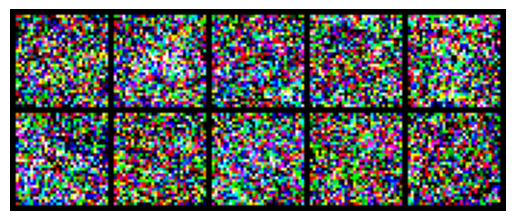

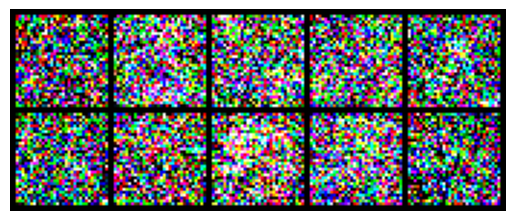

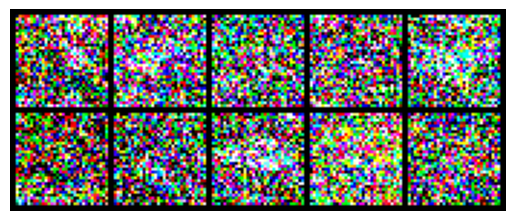

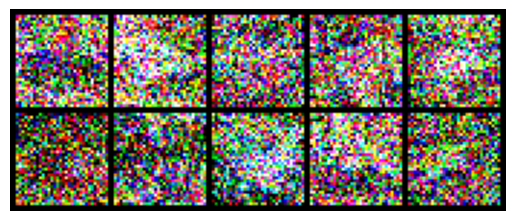

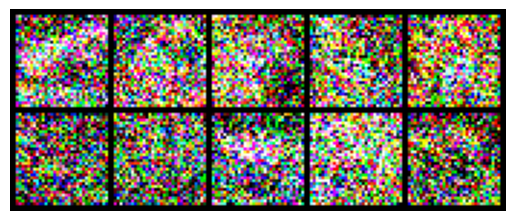

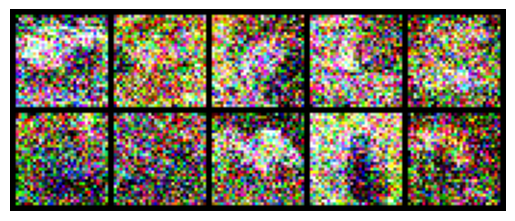

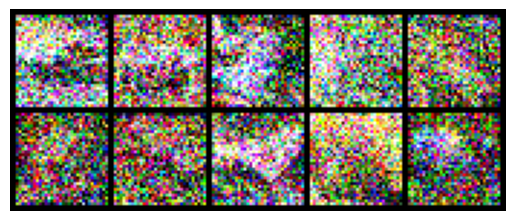

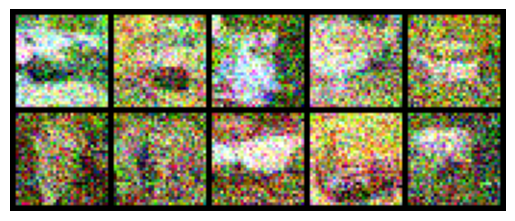

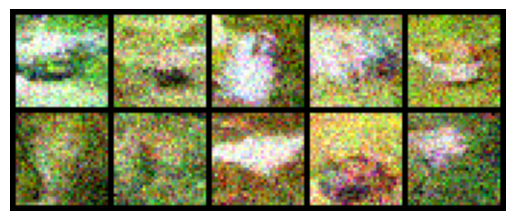

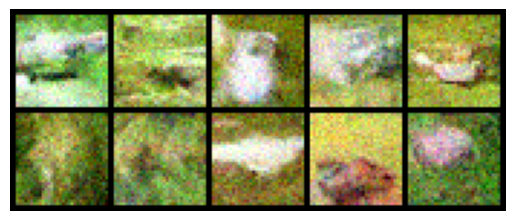

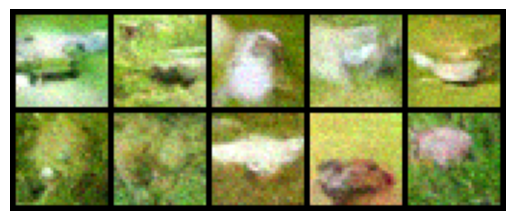

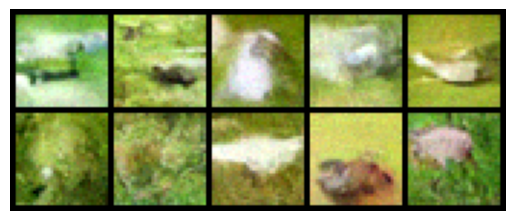

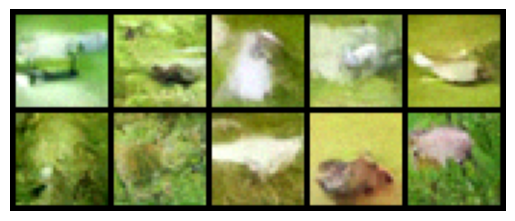

In [ ]:
from torchvision.utils import make_grid

grid_samples = make_grid(samples, nrow=5)

grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
#plt.figure(figsize=(6, 6))
plt.imshow(grid_img)
plt.axis("off")
plt.show()

for step in range(len(history)):
  grid_samples = make_grid(history[step], nrow=5)

  grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
  #plt.figure(figsize=(6, 6))
  plt.imshow(grid_img)
  plt.axis("off")
  plt.show()